In [1]:
# KISS - Keep It Simple Stupid
# https://towardsdatascience.com/convolutional-neural-network-1368ee2998d3
# https://github.com/SkyThonk/real-and-fake-face-detection/blob/master/model.ipynb
# https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection

# ogólne
import tensorflow as tf
import numpy as np

# ładowanie danych
from keras.preprocessing.image import ImageDataGenerator

# budowanie modelu
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, concatenate
from keras.optimizers import Adam
from keras import Sequential, Model, Input

# proces uczenia
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

# wizualizacja
import matplotlib.pyplot as plt
from keras.utils import load_img, plot_model
import pickle
import cv2

# klasyfikacja
from keras.models import load_model

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
tf.config.run_functions_eagerly(True)  
tf.data.experimental.enable_debug_mode()

In [2]:
# Przygotowanie danych
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

path = r"C:\Users\User\Desktop\Matematyka stosowana - II stopień\III semestr\Uczenie ze wzmocnieniem i deeplearning\deep_learning\Zadanie 1"
nbatch = 32

datagen = ImageDataGenerator(validation_split=0.15,
                             # https://stackoverflow.com/questions/66971140/what-rescaling-actually-does-in-tensorflow
                             rescale=1./255,
                             # rotation_range=10.,
                             # https://stackoverflow.com/questions/62484597/understanding-width-shift-range-and-height-shift-range-arguments-in-kerass
                             # width_shift_range=0.1,
                             # height_shift_range=0.1,
                             # zoom_range=0.2,
                             horizontal_flip=True)

train_data = datagen.flow_from_directory(directory=path+r"\train",
                                         target_size=(224,224),
                                         shuffle=True,
                                         color_mode="rgb",
                                         batch_size=nbatch,
                                         class_mode='binary',
                                         subset='training') # set as training data

valid_data = datagen.flow_from_directory(directory=path+r"\train",
                                         target_size=(224,224),
                                         shuffle=True,
                                         color_mode="rgb",
                                         batch_size=nbatch,
                                         class_mode='binary',
                                         subset='validation') # set as validation data

Found 1671 images belonging to 2 classes.
Found 294 images belonging to 2 classes.


(32, 224, 224, 3) (32,)


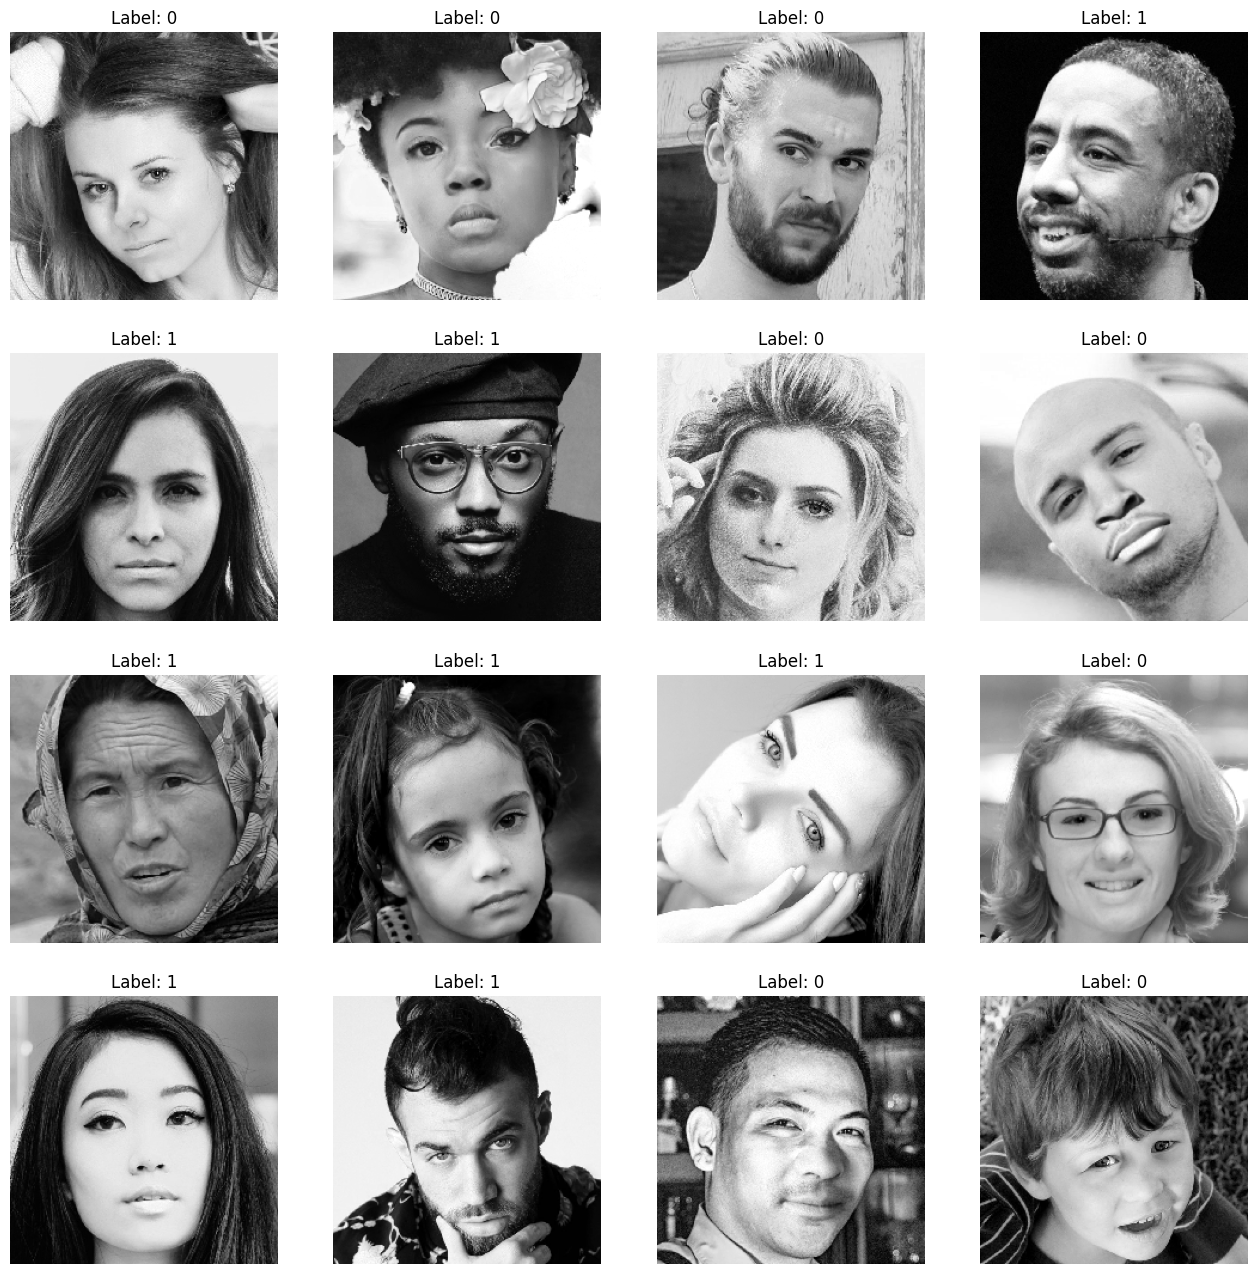

In [3]:
for X, y in train_data:
    print(X.shape, y.shape)
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Label: {}'.format(int(y[i]))) # 1 - REAL; 0 - FAKE
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

In [4]:
unique_train = np.unique(train_data.classes, return_counts=True)
labels_dict_train = dict(zip(unique_train[0], unique_train[1]))
print(labels_dict_train)

unique_valid = np.unique(valid_data.classes, return_counts=True)
labels_dict_valid = dict(zip(unique_valid[0], unique_valid[1]))
print(labels_dict_valid)

{0: 781, 1: 890}
{0: 137, 1: 157}


In [5]:
def get_class_weight(data):
    n_samples = len(data)
    n_classes = len(np.unique(data))

    class_weight = dict()

    for classes in np.unique(data):
        score = n_samples/(n_classes*np.bincount(data)[classes])
        class_weight[classes] = score
        
    return class_weight

In [6]:
class_weights = get_class_weight(train_data.classes)
class_weights

{0: 1.0697823303457106, 1: 0.9387640449438203}

In [7]:
# KISS
# Increasing filters - https://datascience.stackexchange.com/questions/55545/in-cnn-why-do-we-increase-the-number-of-filters-in-deeper-convolution-layers-fo
# BN vs Dropout - https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.1))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.1))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(activation="relu", units=128))
model.add(Dense(activation="sigmoid", units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

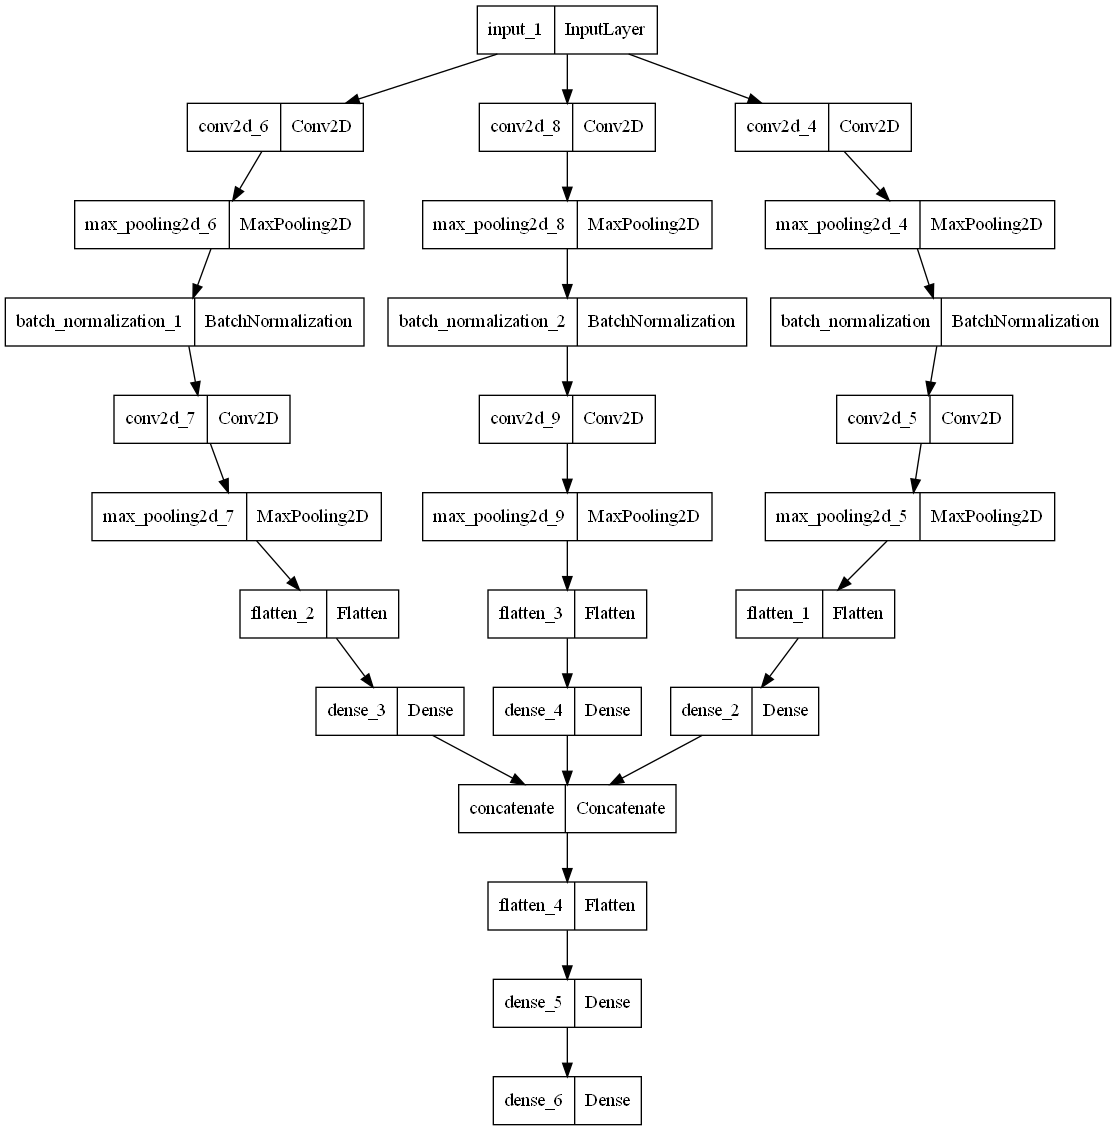

In [8]:
# Parallel KISS
input_shape = Input(shape=(224, 224, 3))


nose = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(input_shape)
nose = MaxPool2D(pool_size=(2,2))(nose)
nose = BatchNormalization()(nose)

nose = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(nose)
nose = MaxPool2D(pool_size=(2,2))(nose)

# nose = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(nose)
# nose = MaxPool2D(pool_size=(2,2))(nose)

# nose = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(nose)
# nose = MaxPool2D(pool_size=(2,2))(nose)

nose = Flatten()(nose)
nose = Dense(activation="relu", units=32)(nose)


face = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(input_shape)
face = MaxPool2D(pool_size=(2,2))(face)
face = BatchNormalization()(face)

face = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(face)
face = MaxPool2D(pool_size=(2,2))(face)

# face = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(face)
# face = MaxPool2D(pool_size=(2,2))(face)

# face = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(face)
# face = MaxPool2D(pool_size=(2,2))(face)

face = Flatten()(face)
face = Dense(activation="relu", units=32)(face)


eyes = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(input_shape)
eyes = MaxPool2D(pool_size=(2,2))(eyes)
eyes = BatchNormalization()(eyes)

eyes = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(eyes)
eyes = MaxPool2D(pool_size=(2,2))(eyes)

# eyes = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(eyes)
# eyes = MaxPool2D(pool_size=(2,2))(eyes)

# eyes = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(eyes)
# eyes = MaxPool2D(pool_size=(2,2))(eyes)

eyes = Flatten()(eyes)
eyes = Dense(activation="relu", units=32)(eyes)


merged = concatenate([face, eyes, nose], axis=1)
merged = Flatten()(merged)

out = Dense(activation="relu", units=32*3)(merged)
out = Dense(activation="sigmoid", units=1)(out)

model = Model(input_shape, out)
plot_model(model)

In [9]:
# porównanie optymalizatorów http://ruder.io/optimizing-gradient-descent/
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss="binary_crossentropy",
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 222, 222, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 222, 222, 16  448         ['input_1[0][0]']                
                                )                                                             

In [11]:
# Hipoteza - val_accuracy jest zgubne, bo zlosliwie albo daje 1 albo 2 i heja
# dodatkowo, po wykresie widac ze loss maleje, a val_acc oscyluje
# Uwaga, kazdorazowe trenowanie modelu, to wciaz jego trenowanie
metric = "val_accuracy" #"val_accuracy", "val_loss"

# String formatting rules - https://mkaz.blog/code/python-string-format-cookbook/
filepath=path+"\\KISS\\models\\"+metric+"\\weights-improvement-epoch{epoch:03d}-loss{val_loss:.3f}-acc{val_accuracy:.3f}.hdf5"

# steps = https://stackoverflow.com/questions/60509425/how-to-use-repeat-function-when-building-data-in-keras
steps = train_data.samples//nbatch
epoch = 100
valid_steps = valid_data.samples//nbatch

checkpoint = ModelCheckpoint(filepath,
                             monitor=metric,
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq="epoch")

early = EarlyStopping(monitor=metric,
                      min_delta=0,
                      patience=int(epoch*0.9), # https://stackoverflow.com/questions/72145506/keras-tuning-cant-find-callback
                      verbose=1,
                      mode='auto')

hist = model.fit(steps_per_epoch=steps,
                 x=train_data,
                 validation_data=valid_data,
                 validation_steps=valid_steps,
                 epochs=epoch,
                 callbacks=[checkpoint,early],
                 class_weight=class_weights) 

Epoch 1/100
32/52 [=================>............] - ETA: 9s - loss: 1.1920 - accuracy: 0.5342

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} ValueError: Could not find callback with key=pyfunc_25 in the registry.
Traceback (most recent call last):

  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\ops\script_ops.py", line 259, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_25 in the registry.


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [ ]:
# zapisanie historii nauki
name = "epochs_{}_steps_{}_{:%Y_%m_%d_%H_%M}".format(checkpoint.params['epochs'], checkpoint.params['steps'], datetime.now())
with open('trainHistoryDict/{}.pickle'.format(name), 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

# # otwarcie historii nauki
# with open('trainHistoryDict/{}.pickle'.format(name), "rb") as file_pi:
#     history = pickle.load(file_pi)

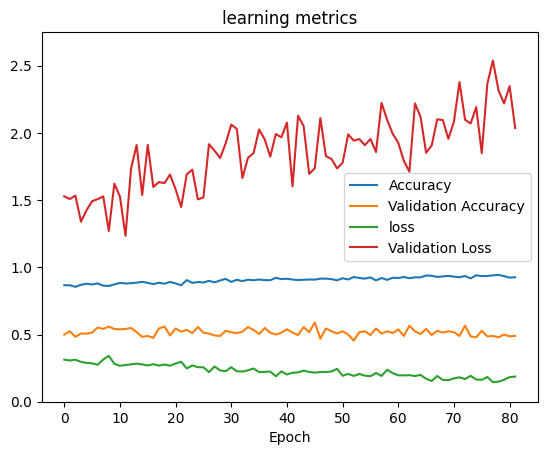

In [ ]:
# https://datascience.stackexchange.com/questions/43191/validation-loss-is-not-decreasing
# https://discuss.pytorch.org/t/why-is-the-validation-loss-increasing/68683

# otwarcie historii nauki
name = "epochs_100_steps_52_2022_11_29_08_04"

with open('trainHistoryDict/{}.pickle'.format(name), "rb") as file_pi:
    history = pickle.load(file_pi)

plt.plot(history["accuracy"])
plt.plot(history['val_accuracy'])
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylim(0, 2.75) 
plt.title("learning metrics")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
# https://stackoverflow.com/questions/52270177/how-to-use-predict-generator-on-new-images-keras
# https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
datagen_test = ImageDataGenerator(rescale=1./255)

test_data = datagen_test.flow_from_directory(directory=path+r"\test",
                                             target_size=(224,224),
                                             shuffle=False,
                                             color_mode="rgb",
                                             class_mode='binary')

test_data.reset() # else weird outputs will come.

folder = "val_loss" #"val_accuracy", "val_loss"

model = load_model("models/"+folder+"/weights-improvement-epoch002-loss0.686-acc0.552.hdf5")

pred=model.predict_generator(test_data, verbose=1)
predicted_class_indices=pred.round().flatten()

labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

Found 25 images belonging to 1 classes.


C:\Users\User\AppData\Local\Temp\ipykernel_67540\2484561489.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_data, verbose=1)


1/1 [==============================] - 0s 483ms/step


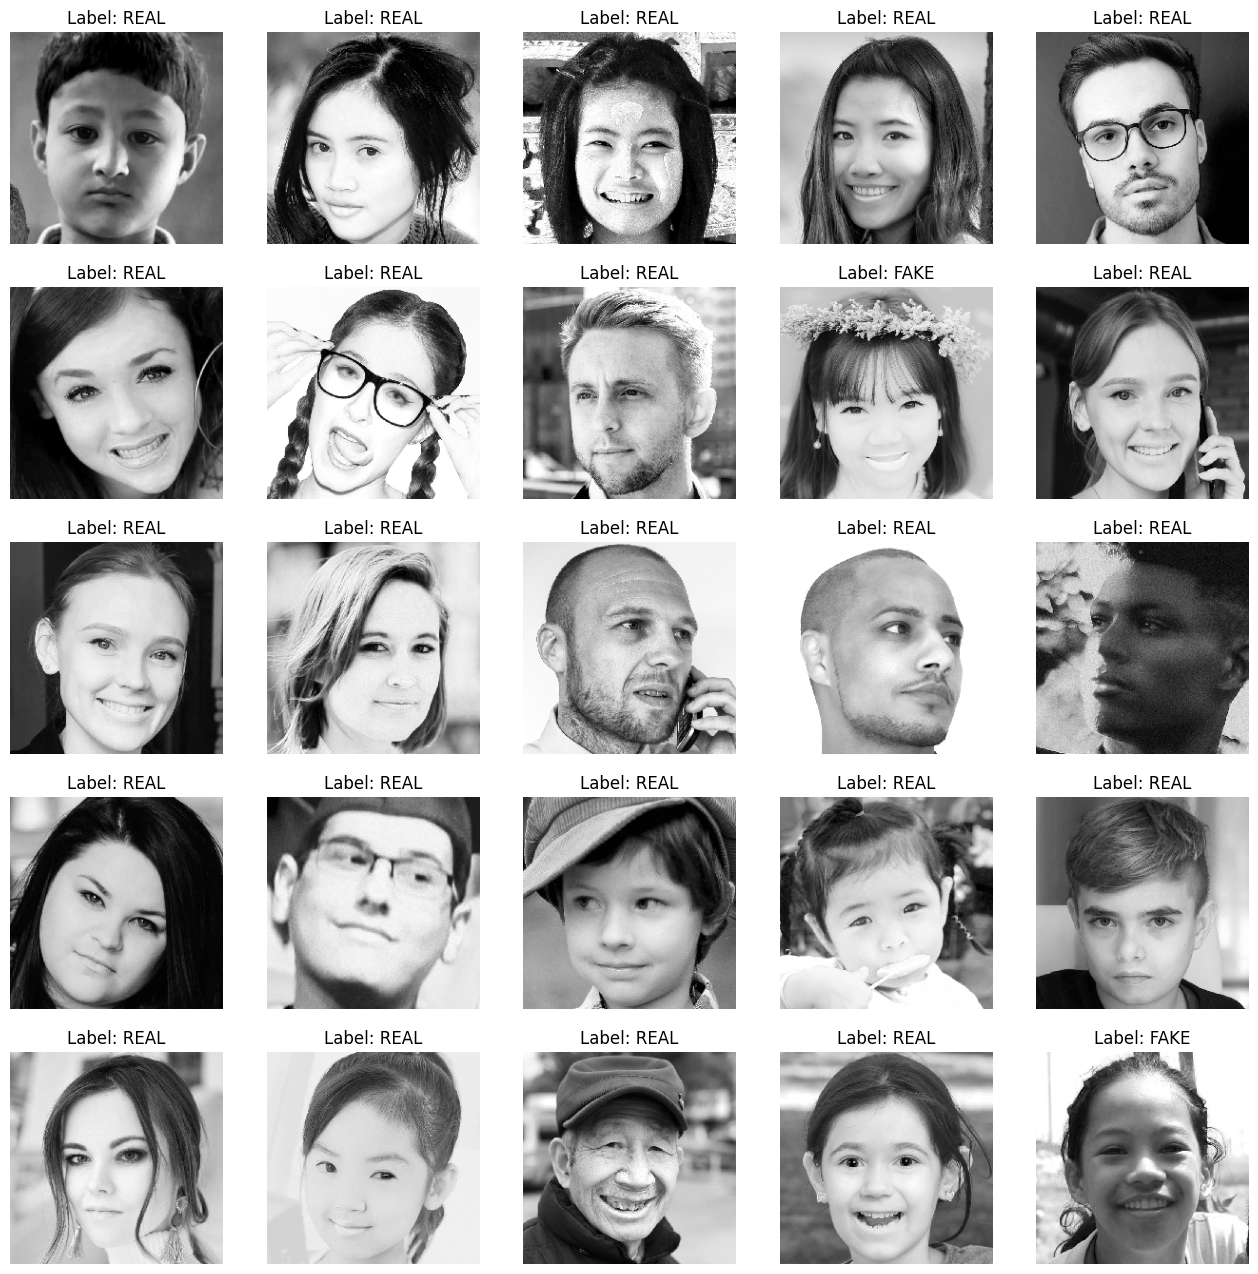

In [ ]:
# WHOLE TEST SET PREDICTION 
for X, _ in test_data:
    plt.figure(figsize=(16,16))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.title('Label: {}'.format(predictions[i]))
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

REAL


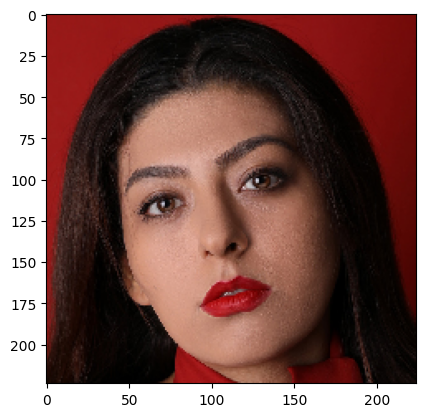

In [ ]:
# SINGLE IMAGE PREDICTION
folder = "val_accuracy" #"val_accuracy", "val_loss"

img = load_img(path+r"\test\TS1\test_image_set1 (6).jpg", target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

saved_model = load_model("models/"+folder+"/weights-improvement-epoch024-loss0.58-acc0.74.hdf5")
output = saved_model.predict(img, verbose=0)

if output[0][0] == 1.:
    print("REAL")
else:
    print('FAKE')